# Import Modules & Util Functions

In [1]:
import os
import sys
import glob
import re
import ast
import warnings
import time

import csv
import json
import pickle

import math
import random
import numpy as np
import scipy as sp
import datetime as dt
import pandas as pd
import swifter
from scipy.stats import gaussian_kde
from scipy.integrate import quad
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

import portion as P
import itertools as it
import copy
from tqdm.notebook import tqdm
from collections import namedtuple
from pprint import pprint
from pytictoc import TicToc

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from myutils import *

# Configure display options
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
%config InlineBackend.figure_format = 'retina'

# Set plot style
# plt.style.use('ggplot')

with open(os.path.join(os.getcwd(), "result_save_path.txt"), "r") as f:
    PATH_TO_RESULTS = f.readline()
    
print(PATH_TO_RESULTS)

/home/wmnlab/F/results


# Manipulate Correlation Coefficient

In [2]:
def manipulate_corr_coef(sr_model_id, dr_model_id, route='BR', mode='zero', rho_force=None):

    def rho_restriction(p, q):
        sigma = max(math.sqrt(p * q * (1 - p) * (1 - q)), 1e-9)  # sigma_x * sigma_y
        R1 = P.closed(-1, 1)  # -1 <= rho <= 1
        R2 = P.closed(-(p * q) / sigma, (1 - p * q) / sigma)  # 0 <= P(X=1, Y=1) <= 1
        R3 = P.closed((p * (1 - q) - 1) / sigma, p * (1 - q) / sigma)  # 0 <= P(X=1, Y=0) <= 1
        R4 = P.closed((q * (1 - p) - 1) / sigma, q * (1 - p) / sigma)  # 0 <= P(X=0, Y=1) <= 1
        R5 = P.closed(-((1 - p) * (1 - q)) / sigma, (1 - (1 - p) * (1 - q)) / sigma)  # 0 <= P(X=0, Y=0) <= 1
        R = R1 & R2 & R3 & R4 & R5
        return R

    def calculate_joint_probabilities(p, q, rho):
        """
        p := P(X = 1); P(X = 0) = 1 - p
        q := P(Y = 1); P(Y = 0) = 1 - q
        rho: correlation coefficient
        a := P(X = 1, Y = 1)
        b := P(X = 1, Y = 0)
        c := P(X = 0, Y = 1)
        d := P(X = 0, Y = 0)
        """
        sigma = max(math.sqrt(p * q * (1 - p) * (1 - q)), 1e-9)  # sigma_x * sigma_y
        a = p * q + rho * sigma
        b = p * (1 - q) - rho * sigma
        c = q * (1 - p) - rho * sigma
        d = (1 - p) * (1 - q) + rho * sigma
        return a, b, c, d

    def calculate_conditional_probabilities(p, q, rho):
        """
        p := P(X = 1); P(X = 0) = 1 - p
        q := P(Y = 1); P(Y = 0) = 1 - q
        rho: correlation coefficient
        alpha := P(Y = 1 | X = 1)
        beta  := P(Y = 1 | X = 0)
        gamma := P(X = 1 | Y = 1)
        delta := P(X = 1 | Y = 0)
        """
        sigma = max(math.sqrt(p * q * (1 - p) * (1 - q)), 1e-9)  # sigma_x * sigma_y
        p = min(max(1e-9, p), 1 - 1e-9)
        q = min(max(1e-9, q), 1 - 1e-9)
        alpha = (p * q + rho * sigma) / p
        beta = (q * (1 - p) - rho * sigma) / (1 - p)
        gamma = (p * q + rho * sigma) / q
        delta = (p * (1 - q) - rho * sigma) / (1 - q)
        return alpha, beta, gamma, delta

    def generate_combos(items):
        combinations_result = list(it.combinations(items, 2))
        self_combinations = [(x, x) for x in items]
        def custom_sort(item):
            return items.index(item[0]), items.index(item[1])
        combos = sorted(self_combinations + combinations_result, key=custom_sort)
        return combos

    def adjust_rho(rho, rho_limit):
        if rho > rho_limit.upper:
            return rho_limit.upper
        elif rho < rho_limit.lower:
            return rho_limit.lower
        else:
            return rho
    
    load_path = os.path.join('.', sr_model_id, dr_model_id, 'models')
    # print(load_path)
    
    with open(os.path.join(load_path, f'{route}_dr_prob_models.pkl'), 'rb') as f:
        dr_prob_models = pickle.load(f)
    dr_prob_models_table = pd.read_csv(os.path.join(load_path, f'{route}_dr_prob_models_table.csv'), index_col=[0, 1])
    
    # print(dr_prob_models)
    # display(dr_prob_models_table)
    
    adjust_table = pd.DataFrame(columns="type1, type2, p, q, rho_lower, rho_upper, rho, alpha, beta, gamma, delta, a, b, c, d, sum".split(", "))
    items = ['LTEH', 'ENBH', 'MCGH', 'MNBH', 'SCGM', 'SCGA', 'SCGR-I', 'SCGR-II', 'SCGC-I', 'SCGC-II', 'SCGF', 'MCGF', 'NASR', 'Stable']
    combos = generate_combos(items)

    for pair in combos:
        row = dr_prob_models_table.loc[pair]
        p, q = row['p'], row['q']
        # rho = row['rho']
        rho_limit = rho_restriction(p, q)
        
        if rho_force is None:
            if mode == 'zero':
                rho_adjust = 0
            elif mode == 'max':
                rho_adjust = rho_limit.upper
            else:
                percentage = int(mode[:-1])
                rho_adjust = percentage * rho_limit.upper / 100
        else:
            rho_adjust = rho_force
        
        alpha, beta, gamma, delta = calculate_conditional_probabilities(p, q, rho_adjust)
        a, b, c, d = calculate_joint_probabilities(p, q, rho_adjust)
        adjust_table.loc[len(adjust_table)] = [pair[0], pair[1], p, q, rho_limit.lower, rho_limit.upper, rho_adjust, alpha, beta, gamma, delta, a, b, c, d, sum([a, b, c, d])]
    
    adjust_table = adjust_table.set_index(['type1', 'type2'])
    
    model_adjust = copy.deepcopy(dr_prob_models)
    for pair in combos:
        row = adjust_table.loc[pair]
        p, q, alpha, beta, gamma, delta = row['p'], row['q'], row['alpha'], row['beta'], row['gamma'], row['delta']
        model_adjust['dl_lost'][pair] = (alpha, beta)
        model_adjust['dl_lost'][(pair[1], pair[0])] = (gamma, delta)
    
    with open(os.path.join(load_path, f'{route}_dr_prob_models_{mode}_corr.pkl'), 'wb') as f:
        pickle.dump(model_adjust, f)
    adjust_table.to_csv(os.path.join(load_path, f'{route}_dr_prob_models_{mode}_corr_table.csv'))
    
    return adjust_table, model_adjust

# Dual Radio Evaluation

In [3]:
class DrEval:
    def __init__(self, filepaths, model_name='Test', model_suffix=None, sr_model_id=None, dr_model_id=None, load_path='.', save_path='.',
                 sp_columns=['type'], ts_column='Timestamp',
                 metrics=['dl_lost']):
        # Initialize instance variables
        self.filepaths = copy.deepcopy(filepaths)
        
        if sr_model_id is None:
            raise TypeError("請輸入SR模型編號")
        else:
            self.sr_model_id = sr_model_id
        
        if dr_model_id is None:
            raise TypeError("請輸入DR模型編號")
        else:
            self.dr_model_id = dr_model_id
        
        self.model_name = model_name
        self.save_path = save_path
        
        self.load_path = os.path.join(load_path, self.sr_model_id, 'models', self.model_name)
        print(self.load_path)
        with open(f'{self.load_path}_kde_models.pkl', 'rb') as f:
            self.kde_models = pickle.load(f)
        with open(f'{self.load_path}_hist_models.pkl', 'rb') as f:
            self.hist_models = pickle.load(f)
        with open(f'{self.load_path}_scope_models.pkl', 'rb') as f:
            self.scope_models = pickle.load(f)
        with open(f'{self.load_path}_plr_models.pkl', 'rb') as f:
            self.plr_models = pickle.load(f)
        with open(f'{self.load_path}_sr_prob_models.pkl', 'rb') as f:
            self.sr_prob_models = pickle.load(f)
            
        self.load_path = os.path.join(load_path, self.sr_model_id, self.dr_model_id, 'models', self.model_name)
        print(self.load_path)
        if model_suffix is None:
            print(f'{self.load_path}_dr_prob_models.pkl')
            with open(f'{self.load_path}_dr_prob_models.pkl', 'rb') as f:
                self.dr_prob_models = pickle.load(f)
        else:
            print(f'{self.load_path}_dr_prob_models_{model_suffix}.pkl')
            with open(f'{self.load_path}_dr_prob_models_{model_suffix}.pkl', 'rb') as f:
                self.dr_prob_models = pickle.load(f)
        self.model_suffix = model_suffix
        
        self.sp_columns = sp_columns[:]
        self.ts_column = ts_column
        self.metrics = metrics[:]
        
        _, _, _, self.figure_id = figure_identity()
        
        # Sample data
        self.LOSS_GT = []
        self.LOSS_EV = []
        self.LOSS_STD = []
        self.DEVICES = []
        self.TRACES = []
        
        # all records
        self.records = []

    @staticmethod
    def generate_random_boolean(probability_true):
        return random.random() < probability_true
    
    @staticmethod
    def interpolate(x, y, ratio=0.5):
        """
        Args:
            x, y (datetime.datetime): x < y
            ratio (float): a decimal numeral in a range [0, 1]; 0 means break at x, 1 means break at y.
        Returns:
            (datetime.datetime): breakpoint of interpolation
        """
        return x + (y - x) * ratio
    
    def hist_method(self, df, ho_df, mode_mets, mets, RATE_TYPE):
        scope = self.scope_models[mode_mets]
        hist_model = self.hist_models[mode_mets]
        prob_model = self.sr_prob_models[mode_mets]
        plr_model = self.plr_models[mode_mets]
        
        this_df = df.copy()
        for i, row in ho_df.iterrows():
            prior_row = ho_df.iloc[i-1] if i != 0 else None
            post_row = ho_df.iloc[i+1] if i != len(ho_df) - 1 else None

            # Peek the next event to avoid HO overlapping with handoverFailure (skip!!)
            if i != len(ho_df) - 1 and pd.notna(row.end) and row.end > post_row.start:
                # print('Overlapping event occurs!!')
                # print(i, row['start'], row['end'], row['type'], row['cause'])
                # print(i+1, post_row['start'], post_row['end'], post_row['type'], post_row['cause'])
                continue
            
            # Set prior event if the prior loop is skipped
            if i != 0 and pd.notna(prior_row.end) and prior_row.end > row.start:
                prior_row = ho_df.iloc[i-2] if i > 1 else None
            
            # Basic information of the current row
            tag = '_'.join([s for s in row[self.sp_columns] if pd.notna(s)])  # specific column name
            start_ts, end_ts = row['start'], row['end']  # handover start/end time
            interruption_time = (end_ts - start_ts).total_seconds() if pd.notna(end_ts) else 0  # handover interruption time
            
            # Set simple left/right bounds
            current_left_bound = start_ts + pd.Timedelta(seconds=(scope[tag][0]))
            current_right_bound = start_ts + pd.Timedelta(seconds=(scope[tag][1]))
            
            # Set left/right bounds to avoid event overlapping with each other
            if prior_row is not None:
                prior_tag = '_'.join([s for s in prior_row[self.sp_columns] if pd.notna(s)])
                prior_right_bound = prior_row['start'] + pd.Timedelta(seconds=(scope[prior_tag][1]))
                if pd.notna(prior_row['end']):
                    left_bound = min(max(current_left_bound, DrEval.interpolate(prior_right_bound, current_left_bound), prior_row['end']), start_ts)
                else:
                    left_bound = min(max(current_left_bound, DrEval.interpolate(prior_right_bound, current_left_bound), prior_row['start']), start_ts)
            else:
                left_bound = current_left_bound
            
            if post_row is not None:
                post_tag = '_'.join([s for s in post_row[self.sp_columns] if pd.notna(s)])
                post_left_bound = post_row['start'] + pd.Timedelta(seconds=(scope[post_tag][0]))
                if pd.notna(end_ts):
                    right_bound = max(min(current_right_bound, DrEval.interpolate(current_right_bound, post_left_bound), post_row['start']), end_ts)
                else:
                    right_bound = max(min(current_right_bound, DrEval.interpolate(current_right_bound, post_left_bound), post_row['start']), start_ts)
            else:
                right_bound = current_right_bound
            
            interval = P.closed(left_bound, right_bound)
            
            # Concatenate PLR from mapping list
            current_df = this_df[this_df['Timestamp'] < interval.upper].copy()
            plr_mapping = hist_model[tag].copy()
            
            current_df[f'relative_time'] = (current_df['Timestamp'] - start_ts).dt.total_seconds()
            current_df[f'window_id'] = ((current_df[f'relative_time'] + 0.005) // 0.01) * 0.01
            
            trigger_probability = prob_model[tag]
            
            if plr_mapping.empty:
                tmp = current_df.copy().rename(columns={mets: f'{mets}_x'})
            else:
                tmp = pd.merge(current_df, plr_mapping, on='window_id', how='left')
                tmp[RATE_TYPE] = tmp[RATE_TYPE].fillna(0)
                
                if not DrEval.generate_random_boolean(trigger_probability):
                    tmp[RATE_TYPE] = 0
            
            tmp['type'] = tag
            
            if i == 0:
                answer = tmp.copy()
            else:
                answer = pd.concat([answer, tmp], axis=0)
            
            # Update dataframe to accelerate the speed
            this_df = this_df[this_df[self.ts_column] >= interval.upper].copy()
        
        answer = pd.concat([answer, this_df], axis=0)
        
        # Consider stable duration
        stable_df = answer[answer['tx_count'].isnull()].copy()[['seq', 'lost_x', 'excl', 'Timestamp']].rename(columns={'lost_x': 'lost'})

        stable_df['Timestamp_sec'] = stable_df['Timestamp'].dt.floor('S')
        stable_df['relative_time'] = (stable_df['Timestamp'] - stable_df['Timestamp_sec']).dt.total_seconds() - 0.5
        stable_df['window_id'] = ((stable_df['relative_time'] + 0.01 / 2) // 0.01) * 0.01

        plr_mapping = hist_model['Stable'].copy()        
        stable_df = pd.merge(stable_df, plr_mapping, on='window_id', how='left').rename(columns={'PLR': 'PLR_if_trigger'})
        trigger_prob_mapping = stable_df[~stable_df['Timestamp_sec'].duplicated()].reset_index(drop=True)[['Timestamp_sec']]
        
        trigger_probability = prob_model['Stable']
        random_bool_array = [DrEval.generate_random_boolean(trigger_probability) for _ in range(len(trigger_prob_mapping))]
        trigger_prob_mapping['trigger'] = random_bool_array

        stable_df = pd.merge(stable_df, trigger_prob_mapping, on='Timestamp_sec', how='left')
        stable_df['PLR'] = stable_df['PLR_if_trigger'] * stable_df['trigger']
        
        stable_df['type'] = 'Stable'

        del stable_df['Timestamp_sec'], stable_df['PLR_if_trigger'], stable_df['trigger']
        
        answer = answer[answer['tx_count'].notnull()].copy()
        
        answer = pd.concat([answer, stable_df], axis=0)
        answer = answer.sort_values(by='Timestamp').reset_index(drop=True)
        answer['PLR'] = answer['PLR'] / 100
        answer['Y'] = answer['PLR'].apply(DrEval.generate_random_boolean)
        
        eval_value = answer['Y'].mean() * 100
        ground_value = df['lost'].mean() * 100
        
        answer = pd.concat([answer[['seq', 'Timestamp', 'type', 'relative_time', 'window_id']],
                            df[['lost']],
                            answer[[RATE_TYPE, 'Y']]], axis=1)
        
        return answer, eval_value, ground_value
    
    
    def setup_profile(self, df, ho_df, df2, scope):
        
        this_df = df2.copy()
        this_df = this_df[this_df['Y']].copy().reset_index(drop=True)
        
        df['anchor_type'] = 'Stable'
        df['anchor_state'] = 0
        for i, row in ho_df.iterrows():
            prior_row = ho_df.iloc[i-1] if i != 0 else None
            post_row = ho_df.iloc[i+1] if i != len(ho_df) - 1 else None

            # Peek the next event to avoid HO overlapping with handoverFailure (skip!!)
            if i != len(ho_df) - 1 and pd.notna(row.end) and row.end > post_row.start:
                # print('Overlapping event occurs!!')
                # print(i, row['start'], row['end'], row['type'], row['cause'])
                # print(i+1, post_row['start'], post_row['end'], post_row['type'], post_row['cause'])
                continue
            
            # Set prior event if the prior loop is skipped
            if i != 0 and pd.notna(prior_row.end) and prior_row.end > row.start:
                prior_row = ho_df.iloc[i-2] if i > 1 else None
            
            # Basic information of the current row
            tag = '_'.join([s for s in row[self.sp_columns] if pd.notna(s)])  # specific column name
            start_ts, end_ts = row['start'], row['end']  # handover start/end time
            interruption_time = (end_ts - start_ts).total_seconds() if pd.notna(end_ts) else 0  # handover interruption time
            
            # Set simple left/right bounds
            current_left_bound = start_ts + pd.Timedelta(seconds=(scope[tag][0]))
            current_right_bound = start_ts + pd.Timedelta(seconds=(scope[tag][1]))
            
            # Set left/right bounds to avoid event overlapping with each other
            if prior_row is not None:
                prior_tag = '_'.join([s for s in prior_row[self.sp_columns] if pd.notna(s)])
                prior_right_bound = prior_row['start'] + pd.Timedelta(seconds=(scope[prior_tag][1]))
                if pd.notna(prior_row['end']):
                    left_bound = min(max(current_left_bound, DrEval.interpolate(prior_right_bound, current_left_bound), prior_row['end']), start_ts)
                else:
                    left_bound = min(max(current_left_bound, DrEval.interpolate(prior_right_bound, current_left_bound), prior_row['start']), start_ts)
            else:
                left_bound = current_left_bound
            
            if post_row is not None:
                post_tag = '_'.join([s for s in post_row[self.sp_columns] if pd.notna(s)])
                post_left_bound = post_row['start'] + pd.Timedelta(seconds=(scope[post_tag][0]))
                if pd.notna(end_ts):
                    right_bound = max(min(current_right_bound, DrEval.interpolate(current_right_bound, post_left_bound), post_row['start']), end_ts)
                else:
                    right_bound = max(min(current_right_bound, DrEval.interpolate(current_right_bound, post_left_bound), post_row['start']), start_ts)
            else:
                right_bound = current_right_bound
            
            interval = P.closed(left_bound, right_bound)
            
            df.loc[(df['start'] >= interval.lower) & (df['start'] < interval.upper), 'anchor_type'] = tag
            
            if not this_df[(this_df['Timestamp'] >= interval.lower) & (this_df['Timestamp'] < interval.upper)].empty:
                df.loc[(df['start'] >= interval.lower) & (df['start'] < interval.upper), 'anchor_state'] = 1
                
            # Update dataframe to accelerate the speed
            this_df = this_df[this_df[self.ts_column] >= interval.upper].copy()
            
        return df
    
    
    def hist_method_dual(self, df, ho_df, mode_mets, mets, RATE_TYPE):
        scope = self.scope_models[mode_mets]
        hist_model = self.hist_models[mode_mets]
        dr_prob_model = self.dr_prob_models[mode_mets]
        
        this_df = df.copy()
        for i, row in ho_df.iterrows():
            prior_row = ho_df.iloc[i-1] if i != 0 else None
            post_row = ho_df.iloc[i+1] if i != len(ho_df) - 1 else None

            # Peek the next event to avoid HO overlapping with handoverFailure (skip!!)
            if i != len(ho_df) - 1 and pd.notna(row.end) and row.end > post_row.start:
                # print('Overlapping event occurs!!')
                # print(i, row['start'], row['end'], row['type'], row['cause'])
                # print(i+1, post_row['start'], post_row['end'], post_row['type'], post_row['cause'])
                continue
            
            # Set prior event if the prior loop is skipped
            if i != 0 and pd.notna(prior_row.end) and prior_row.end > row.start:
                prior_row = ho_df.iloc[i-2] if i > 1 else None
            
            # Basic information of the current row
            tag = '_'.join([s for s in row[self.sp_columns] if pd.notna(s)])  # specific column name
            start_ts, end_ts = row['start'], row['end']  # handover start/end time
            interruption_time = (end_ts - start_ts).total_seconds() if pd.notna(end_ts) else 0  # handover interruption time
            
            # Set simple left/right bounds
            current_left_bound = start_ts + pd.Timedelta(seconds=(scope[tag][0]))
            current_right_bound = start_ts + pd.Timedelta(seconds=(scope[tag][1]))
            
            # Set left/right bounds to avoid event overlapping with each other
            if prior_row is not None:
                prior_tag = '_'.join([s for s in prior_row[self.sp_columns] if pd.notna(s)])
                prior_right_bound = prior_row['start'] + pd.Timedelta(seconds=(scope[prior_tag][1]))
                if pd.notna(prior_row['end']):
                    left_bound = min(max(current_left_bound, DrEval.interpolate(prior_right_bound, current_left_bound), prior_row['end']), start_ts)
                else:
                    left_bound = min(max(current_left_bound, DrEval.interpolate(prior_right_bound, current_left_bound), prior_row['start']), start_ts)
            else:
                left_bound = current_left_bound
            
            if post_row is not None:
                post_tag = '_'.join([s for s in post_row[self.sp_columns] if pd.notna(s)])
                post_left_bound = post_row['start'] + pd.Timedelta(seconds=(scope[post_tag][0]))
                if pd.notna(end_ts):
                    right_bound = max(min(current_right_bound, DrEval.interpolate(current_right_bound, post_left_bound), post_row['start']), end_ts)
                else:
                    right_bound = max(min(current_right_bound, DrEval.interpolate(current_right_bound, post_left_bound), post_row['start']), start_ts)
            else:
                right_bound = current_right_bound
            
            interval = P.closed(left_bound, right_bound)
            
            # Concatenate PLR from mapping list
            current_df = this_df[this_df['Timestamp'] < interval.upper].copy()
            plr_mapping = hist_model[tag].copy()
            
            current_df[f'relative_time'] = (current_df['Timestamp'] - start_ts).dt.total_seconds()
            current_df[f'window_id'] = ((current_df[f'relative_time'] + 0.005) // 0.01) * 0.01
            
            anchor_tag = row['anchor_type']
            anchor_state = row['anchor_state']
            
            if anchor_state == 1:
                trigger_probability = dr_prob_model[(anchor_tag, tag)][0]
            else:
                trigger_probability = dr_prob_model[(anchor_tag, tag)][1]
            
            if plr_mapping.empty:
                tmp = current_df.copy().rename(columns={mets: f'{mets}_x'})
            else:
                tmp = pd.merge(current_df, plr_mapping, on='window_id', how='left')
                tmp[RATE_TYPE] = tmp[RATE_TYPE].fillna(0)
                
                if not DrEval.generate_random_boolean(trigger_probability):
                    tmp[RATE_TYPE] = 0
            
            tmp['anchor_type'] = anchor_tag
            tmp['anchor_state'] = anchor_state
            tmp['type'] = tag
            
            if i == 0:
                answer = tmp.copy()
            else:
                answer = pd.concat([answer, tmp], axis=0)
            
            # Update dataframe to accelerate the speed
            this_df = this_df[this_df[self.ts_column] >= interval.upper].copy()
        
        answer = pd.concat([answer, this_df], axis=0)
        # display(answer)
        
        # Consider stable duration
        stable_df = answer[answer['tx_count'].isnull()].copy()[['seq', 'lost_x', 'excl', 'Timestamp']].rename(columns={'lost_x': 'lost'})

        stable_df['Timestamp_sec'] = stable_df['Timestamp'].dt.floor('S')
        stable_df['relative_time'] = (stable_df['Timestamp'] - stable_df['Timestamp_sec']).dt.total_seconds() - 0.5
        stable_df['window_id'] = ((stable_df['relative_time'] + 0.01 / 2) // 0.01) * 0.01

        plr_mapping = hist_model['Stable'].copy()        
        stable_df = pd.merge(stable_df, plr_mapping, on='window_id', how='left').rename(columns={'PLR': 'PLR_if_trigger'})
        trigger_prob_mapping = stable_df[~stable_df['Timestamp_sec'].duplicated()].reset_index(drop=True)[['Timestamp_sec']]
        
        trigger_probability = dr_prob_model[('Stable', 'Stable')][0]
        
        # if anchor_state == 1:
        #     trigger_probability = dr_prob_model[(anchor_tag, tag)][0]
        # else:
        #     trigger_probability = dr_prob_model[(anchor_tag, tag)][1]
                
        random_bool_array = [DrEval.generate_random_boolean(trigger_probability) for _ in range(len(trigger_prob_mapping))]
        trigger_prob_mapping['trigger'] = random_bool_array

        stable_df = pd.merge(stable_df, trigger_prob_mapping, on='Timestamp_sec', how='left')
        stable_df['PLR'] = stable_df['PLR_if_trigger'] * stable_df['trigger']
        
        # stable_df['type'] = 'Stable'
        stable_df['anchor_type'] = 'Stable'
        stable_df['anchor_state'] = 0
        stable_df['type'] = 'Stable'

        del stable_df['Timestamp_sec'], stable_df['PLR_if_trigger'], stable_df['trigger']
        
        answer = answer[answer['tx_count'].notnull()].copy()
        
        answer = pd.concat([answer, stable_df], axis=0)
        answer = answer.sort_values(by='Timestamp').reset_index(drop=True)
        answer['PLR'] = answer['PLR'] / 100
        answer['Y'] = answer['PLR'].apply(DrEval.generate_random_boolean)
        
        eval_value = answer['Y'].mean() * 100
        ground_value = df['lost'].mean() * 100
        
        answer = pd.concat([answer[['seq', 'Timestamp', 'anchor_type', 'anchor_state', 'type', 'relative_time', 'window_id']],
                            df[['lost']],
                            answer[[RATE_TYPE, 'Y']]], axis=1)

        return answer, eval_value, ground_value

        # return answer, eval_value, ground_value
        
        # # Consider stable duration
        # stable_df = answer[answer['tx_count'].isnull()].copy()[['seq', 'lost_x', 'excl', 'Timestamp']].rename(columns={'lost_x': 'lost'})

        # stable_df['Timestamp_sec'] = stable_df['Timestamp'].dt.floor('S')
        # stable_df['relative_time'] = (stable_df['Timestamp'] - stable_df['Timestamp_sec']).dt.total_seconds() - 0.5
        # stable_df['window_id'] = ((stable_df['relative_time'] + 0.01 / 2) // 0.01) * 0.01

        # plr_mapping = hist_model['Stable'].copy()
        # stable_df = pd.merge(stable_df, plr_mapping, on='window_id', how='left').rename(columns={'PLR': 'PLR_trig'})

        # trig_p_mapping = stable_df[~stable_df['Timestamp_sec'].duplicated()].reset_index(drop=True)
        
        # triggered_p = dr_prob_model[('Stable', 'Stable')][0]
        
        # random_bool_array = [DrEval.generate_random_boolean(triggered_p) for _ in range(len(trig_p_mapping))]
        # trig_p_mapping['trigger'] = random_bool_array
        # trig_p_mapping = trig_p_mapping[['Timestamp_sec', 'trigger']]

        # stable_df = pd.merge(stable_df, trig_p_mapping, on='Timestamp_sec', how='left')
        # stable_df['PLR'] = stable_df['PLR_trig'] * stable_df['trigger']

        # del stable_df['Timestamp_sec'], stable_df['PLR_trig'], stable_df['trigger']
        
        # answer = answer[answer['tx_count'].notnull()].copy()
        # # display(answer)
        
        # answer = pd.concat([answer, stable_df], axis=0)
        # answer = answer.sort_values(by='Timestamp').reset_index(drop=True)
        # answer['PLR'] = answer['PLR'] / 100
        # answer['Y'] = answer['PLR'].apply(DrEval.generate_random_boolean)
        
        # eval_value = answer['Y'].mean() * 100
        # ground_value = df['lost'].mean() * 100
    
    
    def run_hist_method(self, N=3):
        scope = self.scope_models['dl_lost']
        n = len(self.filepaths)
        for mode_mets in ['dl_lost']:
            for i, filepath in enumerate(self.filepaths):
                
                # if i > 35:
                #     break
                
                # if i > 0:
                #     break
                
                print(f'{i}/{n}', filepath[0][0]); print(f'{i}/{n}', filepath[0][1]); print(f'{i}/{n}', filepath[0][2])
                print(f'{i}/{n}', filepath[1][0]); print(f'{i}/{n}', filepath[1][1]); print(f'{i}/{n}', filepath[1][2])
                
                # ho_df1 = pd.read_csv(filepath[0][0], parse_dates=['start', 'end'])
                if os.path.isfile(filepath[0][0]):
                    ho_df1 = pd.read_csv(filepath[0][0], parse_dates=['start', 'end'])
                else:
                    print('{} does not exist!!!'.format(filepath[0][0]))
                    temp_dir = os.path.dirname(filepath[0][0])
                    rrc_file = [os.path.join(temp_dir, s) for s in os.listdir(temp_dir) if s.endswith('rrc.csv')][0]
                    ho_df1, _ = mi_parse_handover(pd.read_csv(rrc_file))
                    print('makefile:', os.path.join(temp_dir, 'handover_info_log.csv'))
                    ho_df1.to_csv(os.path.join(temp_dir, 'handover_info_log.csv'), index=False)
                
                # ho_df2 = pd.read_csv(filepath[1][0], parse_dates=['start', 'end'])
                if os.path.isfile(filepath[1][0]):
                    ho_df2 = pd.read_csv(filepath[1][0], parse_dates=['start', 'end'])
                else:
                    print('{} does not exist!!!'.format(filepath[1][0]))
                    temp_dir = os.path.dirname(filepath[1][0])
                    rrc_file = [os.path.join(temp_dir, s) for s in os.listdir(temp_dir) if s.endswith('rrc.csv')][0]
                    ho_df2, _ = mi_parse_handover(pd.read_csv(rrc_file))
                    print('makefile:', os.path.join(temp_dir, 'handover_info_log.csv'))
                    ho_df2.to_csv(os.path.join(temp_dir, 'handover_info_log.csv'), index=False)
                
                if ho_df1.empty or ho_df2.empty:
                    print('******** Empty RRC Data ********')
                    continue
                
                # df, ho_df, empty_data = data_aligner(df, ho_df)
                
                df1 = pd.read_csv(filepath[0][1], parse_dates=['Timestamp'])[['seq', 'Timestamp', 'lost', 'excl', 'latency']]
                df2 = pd.read_csv(filepath[1][1], parse_dates=['Timestamp'])[['seq', 'Timestamp', 'lost', 'excl', 'latency']]
                df1, ho_df1, empty_data1 = data_aligner(df1, ho_df1)
                df2, ho_df2, empty_data2 = data_aligner(df2, ho_df2)
                
                if empty_data1 or empty_data2:
                    print('******** Empty RRC Data ********')
                    continue
                
                df = pd.merge(df1, df2, on='seq', how='inner').reset_index(drop=True)
                
                df1 = df[['seq', 'Timestamp_x', 'lost_x', 'excl_x', 'latency_x']].rename(columns={'Timestamp_x': 'Timestamp', 'lost_x': 'lost', 'excl_x': 'excl', 'latency_x': 'latency'})
                df2 = df[['seq', 'Timestamp_y', 'lost_y', 'excl_y', 'latency_y']].rename(columns={'Timestamp_y': 'Timestamp', 'lost_y': 'lost', 'excl_y': 'excl', 'latency_y': 'latency'})
                
                loss_rate_list = []
                answer = None
                for iter_round in tqdm(range(N), ncols=1000):
                    ans1, eval_value1, ground_value1 = eval.hist_method(df1, ho_df1, mode_mets='dl_lost', mets='lost', RATE_TYPE='PLR')
                    # display(answer1)
                    
                    # setup_profile
                    # ho_df1 = self.setup_profile(ho_df1, ho_df2, df2, scope)
                    avatar_ho_df2 = self.setup_profile(ho_df2.copy(), ho_df1, ans1, scope)
                    
                    # display(avatar_ho_df2)
                    
                    ans2, eval_value2, ground_value2 = eval.hist_method_dual(df2, avatar_ho_df2, mode_mets='dl_lost', mets='lost', RATE_TYPE='PLR')
                    
                    # display(ans1)
                    # display(ans2)
                    # display(answer2)
                    
                    ans = pd.merge(ans1, ans2, on='seq', how='inner').reset_index(drop=True)
                    ans['lost'] = (ans['lost_x']) & (ans['lost_y'])
                    ans['Y'] = (ans['Y_x']) & (ans['Y_y'])
                    ans = ans[['seq', 'Timestamp_x', 'Timestamp_y', 'type_x', 'anchor_type', 'anchor_state', 'type_y', 'relative_time_x', 'window_id_x', 'relative_time_y', 'window_id_y', 'lost_x', 'lost_y', 'lost', 'PLR_x', 'Y_x', 'PLR_y', 'Y_y', 'Y']]
                    
                    # display(ans)
                    
                    handle = (ans1['Y']) & (ans2['Y'])
                    eval_value = handle.mean() * 100
                    # print('eval:', eval_value, len(handle))
                    
                    handle = (df1['lost']) & (df2['lost'])
                    ground_value = handle.mean() * 100
                    # print('ground:', ground_value, len(handle))
                    
                    if answer is None:
                        answer = ans.copy()
                        answer = answer.rename(columns={'PLR_x': f'PLR_x_0', 'Y_x': f'Y_x_0', 'PLR_y': f'PLR_y_0', 'Y_y': f'Y_y_0', 'Y': f'Y_0'})
                    else:
                        answer = pd.concat([answer, ans[['PLR_x', 'Y_x', 'PLR_y', 'Y_y', 'Y']]], axis=1)
                        answer = answer.rename(columns={'PLR_x': f'PLR_x_{iter_round}', 'Y_x': f'Y_x_{iter_round}', 'PLR_y': f'PLR_y_{iter_round}', 'Y_y': f'Y_y_{iter_round}', 'Y': f'Y_{iter_round}'})
                    
                    loss_rate_list.append(eval_value)
                
                # display(answer)
        
                mean_value = np.mean(loss_rate_list)
                std_deviation = np.std(loss_rate_list)

                # print()
                # print("Mean:", mean_value)
                # print("Standard Deviation:", std_deviation)
                # print("Ground Truth:", ground_value)
                
                self.LOSS_GT.append(ground_value)
                self.LOSS_EV.append(mean_value)
                self.LOSS_STD.append(std_deviation)
                
                path1 = filepath[0][1]
                path2 = filepath[1][1]
                
                error = mean_value - ground_value
                self.records.append((mean_value, std_deviation, ground_value, error, path1, path2))

                def find_sm_label(path):
                    # 找到 "sm" 的位置
                    sm_index = path.index("sm")
                    # 从 "sm" 的位置开始找到下一个斜杠 "/"
                    next_slash_index = path.index("/", sm_index)
                    # 截取 "sm00" 标签
                    # sm_label = path[sm_index:next_slash_index]
                    sm_label = path[sm_index+2:next_slash_index]
                    # print("截取的标签为:", sm_label)
                    return sm_label
                
                self.DEVICES.append(find_sm_label(path1)+'+'+find_sm_label(path2))
                
                def find_tr_label(path):
                    # 找到 "sm" 的位置
                    sm_index = path.index("#")
                    # 从 "sm" 的位置开始找到下一个斜杠 "/"
                    next_slash_index = path.index("/", sm_index)
                    # 截取 "sm00" 标签
                    # sm_label = path[sm_index:next_slash_index]
                    sm_label = path[sm_index+1:next_slash_index]
                    # print("截取的标签为:", sm_label)
                    return sm_label
                
                self.TRACES.append(find_tr_label(path1)+'+'+find_tr_label(path2))
                
                if self.model_suffix is None:
                    # save_path = os.path.join(self.save_path, self.sr_model_id, self.dr_model_id, 'results', self.figure_id)
                    save_path = os.path.join(PATH_TO_RESULTS, self.sr_model_id, 'dr_results', self.dr_model_id, self.figure_id)
                else:
                    # save_path = os.path.join(self.save_path, self.sr_model_id, self.dr_model_id, 'results', f'{self.figure_id}_{self.model_suffix}')
                    save_path = os.path.join(PATH_TO_RESULTS, self.sr_model_id, 'dr_results', self.dr_model_id, f'{self.figure_id}_{self.model_suffix}')
                    
                if not os.path.isdir(save_path):
                    os.makedirs(save_path)
                
                save_path = os.path.join(save_path, path1.replace('/', '\\')[:-4]+path2.replace('/', '\\'))
                print(save_path)
                answer.to_csv(save_path, index=False)
    
    
    def plot(self, save_name='plot_example', save_path='.'):
        # Sample data
        x = self.LOSS_GT.copy()
        y = self.LOSS_EV.copy()

        # Standard deviations for error bars
        y_error = self.LOSS_STD.copy()

        # Create figure and axes
        fig, ax = plt.subplots(figsize=(6, 4))

        # Scatter plot with error bars and horizontal caps
        ax.errorbar(x, y, yerr=y_error, linestyle='None', marker='o', color='tab:blue', capsize=5)
        ax.scatter([], [], linestyle='None', marker='o', color='tab:blue', label='Data Points')

        # Regression line
        # coefficients = np.polyfit(x, y, 1)
        # regression_line = np.poly1d(coefficients)
        # ax.plot(ax.get_xlim(), regression_line(ax.get_xlim()), linestyle='--', linewidth=1.1, color='tab:blue', label='Regression Line')

        # Annotate the slope of the regression line
        # slope_annotation = f'Slope: {coefficients[0]:.2f}'
        # ax.annotate(slope_annotation, xy=(0.5, 0.85), xycoords='axes fraction', fontsize=10, fontstyle='italic', fontweight='bold', color='tab:blue')

        # Annotate MSE From the regression line
        # y_pred = regression_line(x)
        # mse = mean_squared_error(y, y_pred)
        mse = np.sqrt(mean_squared_error(x, y))
        mse_rate = mse / np.mean(x) * 100
        slope_annotation = f'RMSE: {mse:.3f} ({mse_rate:.1f} %)'
        ax.annotate(slope_annotation, xy=(0.5, 0.85), xycoords='axes fraction', fontsize=10, fontstyle='italic', fontweight='bold', color='tab:blue')

        # 45-Degree Line
        ax.plot(ax.get_xlim(), ax.get_xlim(), linestyle='-', linewidth=1.1, color='tab:pink', label='45-Degree Line', alpha=0.9)
        # ax.plot(ax.get_xlim(), 1.1 * ax.get_xlim(), linestyle='-', linewidth=1.1, color='tab:pink', label='45-Degree Line', alpha=0.9)
        # ax.plot(ax.get_xlim(), 0.9 * ax.get_xlim(), linestyle='-', linewidth=1.1, color='tab:pink', label='45-Degree Line', alpha=0.9)
        
        # 获取 x 的边界
        x_limits = ax.get_xlim()

        # 创建 x 值范围
        x_values = np.linspace(x_limits[0], x_limits[1], 100)  # 使用 x 的边界值作为范围

        # 计算 y = 1.1x 和 y = 0.9x 的值
        y_upper = 1.1 * x_values
        y_lower = 0.9 * x_values

        # 绘制 y = 1.1x 和 y = 0.9x 线
        ax.plot(x_values, y_upper, linestyle='-', linewidth=1.1, color='tab:orange')
        ax.plot(x_values, y_lower, linestyle='-', linewidth=1.1, color='tab:orange')

        # 在两条线之间填充颜色
        ax.fill_between(x_values, y_lower, y_upper, color='tab:orange', alpha=0.3)

        # Set labels and title
        ax.set_xlabel('PLR Ground Truth')
        ax.set_ylabel('PLR Evaluated')
        # ax.set_title('A Profile Evaluate 9 Traces From A5 Data: Single')

        for i, sm_label in enumerate(self.DEVICES):
            ax.annotate(sm_label, xy=(x[i], y[i]))
            
        # Add a legend
        ax.legend()
        
        save_path = os.path.join(save_path, self.sr_model_id, self.dr_model_id, 'figures')
        if not os.path.isdir(save_path):
            os.makedirs(save_path)
        
        if self.model_suffix is not None:
            save_name = f'{save_name}_{self.model_suffix}'
        save_path = os.path.join(save_path, figure_add_prefix_suffix(save_name, image_id=self.figure_id))
        print(save_path)
        fig.savefig(save_path, dpi=300)

        # Show the plot
        plt.show()

# Enter Model IDs

In [4]:
sr_model_id = '20240329_160006be6c_new_dataset_sync'
dr_model_id = 'dr_20240329_1700005690'
print('SR Model ID:', sr_model_id)
print('DR Model ID:', dr_model_id)

mode = ['zero', 'max', '25%', '50%', '75%']
mode = 'zero'
suffix = f'{mode}_corr'
print('Suffix:', suffix)

SR Model ID: 20240329_160006be6c_new_dataset_sync
DR Model ID: dr_20240329_1700005690
Suffix: zero_corr


# BR: DR Eval

In [5]:
adjust_table, model_adjust = manipulate_corr_coef(sr_model_id, dr_model_id, route='BR', mode=mode, rho_force=None)
# display(adjust_table)
# pprint(model_adjust)

In [6]:
# Dual Radio Example
# dates = data_loader(query_dates=True, show_info=True)

# selected_dates = [s for s in dates if s >= '2023-09-12']
selected_dates = ['2024-03-19']
# excluded_dates = []
# selected_exps = []
# excluded_exps = ['Modem_Action_Test', 'Control_Group', 'Control_Group2', 'Control_Group3']
selected_routes = ['BR']
# excluded_routes = []
filepaths = data_loader(mode='dr', selected_dates=selected_dates, selected_routes=selected_routes)

# print(len(filepaths[:36]))
# pprint(filepaths[:36])

./20240329_160006be6c_new_dataset_sync/models/BR
./20240329_160006be6c_new_dataset_sync/dr_20240329_1700005690/models/BR
./20240329_160006be6c_new_dataset_sync/dr_20240329_1700005690/models/BR_dr_prob_models_adjust.pkl
0/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#01/data/handover_info_log.csv
0/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#01/data/udp_dnlk_loss_latency.csv
0/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#01/data/udp_uplk_loss_latency.csv
0/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#01/data/handover_info_log.csv
0/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#01/data/udp_dnlk_loss_latency.csv
0/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm00\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm01\#01\data\udp_dnlk_loss_latency.csv
1/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#01/data/handover_info_log.csv
1/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#01/data/udp_dnlk_loss_latency.csv
1/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#01/data/udp_uplk_loss_latency.csv
1/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#01/data/handover_info_log.csv
1/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#01/data/udp_dnlk_loss_latency.csv
1/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm00\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm02\#01\data\udp_dnlk_loss_latency.csv
2/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#01/data/handover_info_log.csv
2/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#01/data/udp_dnlk_loss_latency.csv
2/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#01/data/udp_uplk_loss_latency.csv
2/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#01/data/handover_info_log.csv
2/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#01/data/udp_dnlk_loss_latency.csv
2/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm00\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm03\#01\data\udp_dnlk_loss_latency.csv
3/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#01/data/handover_info_log.csv
3/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#01/data/udp_dnlk_loss_latency.csv
3/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#01/data/udp_uplk_loss_latency.csv
3/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#01/data/handover_info_log.csv
3/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#01/data/udp_dnlk_loss_latency.csv
3/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm00\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm04\#01\data\udp_dnlk_loss_latency.csv
4/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#01/data/handover_info_log.csv
4/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#01/data/udp_dnlk_loss_latency.csv
4/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#01/data/udp_uplk_loss_latency.csv
4/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#01/data/handover_info_log.csv
4/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#01/data/udp_dnlk_loss_latency.csv
4/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm00\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm05\#01\data\udp_dnlk_loss_latency.csv
5/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#01/data/handover_info_log.csv
5/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#01/data/udp_dnlk_loss_latency.csv
5/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#01/data/udp_uplk_loss_latency.csv
5/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#01/data/handover_info_log.csv
5/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#01/data/udp_dnlk_loss_latency.csv
5/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm00\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm06\#01\data\udp_dnlk_loss_latency.csv
6/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#01/data/handover_info_log.csv
6/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#01/data/udp_dnlk_loss_latency.csv
6/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#01/data/udp_uplk_loss_latency.csv
6/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#01/data/handover_info_log.csv
6/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#01/data/udp_dnlk_loss_latency.csv
6/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm00\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm07\#01\data\udp_dnlk_loss_latency.csv
7/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#01/data/handover_info_log.csv
7/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#01/data/udp_dnlk_loss_latency.csv
7/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#01/data/udp_uplk_loss_latency.csv
7/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#01/data/handover_info_log.csv
7/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#01/data/udp_dnlk_loss_latency.csv
7/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm00\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm08\#01\data\udp_dnlk_loss_latency.csv
8/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#01/data/handover_info_log.csv
8/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#01/data/udp_dnlk_loss_latency.csv
8/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#01/data/udp_uplk_loss_latency.csv
8/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#01/data/handover_info_log.csv
8/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#01/data/udp_dnlk_loss_latency.csv
8/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm01\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm02\#01\data\udp_dnlk_loss_latency.csv
9/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#01/data/handover_info_log.csv
9/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#01/data/udp_dnlk_loss_latency.csv
9/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#01/data/udp_uplk_loss_latency.csv
9/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#01/data/handover_info_log.csv
9/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#01/data/udp_dnlk_loss_latency.csv
9/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm01\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm03\#01\data\udp_dnlk_loss_latency.csv
10/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#01/data/handover_info_log.csv
10/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#01/data/udp_dnlk_loss_latency.csv
10/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#01/data/udp_uplk_loss_latency.csv
10/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#01/data/handover_info_log.csv
10/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#01/data/udp_dnlk_loss_latency.csv
10/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm01\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm04\#01\data\udp_dnlk_loss_latency.csv
11/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#01/data/handover_info_log.csv
11/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#01/data/udp_dnlk_loss_latency.csv
11/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#01/data/udp_uplk_loss_latency.csv
11/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#01/data/handover_info_log.csv
11/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#01/data/udp_dnlk_loss_latency.csv
11/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm01\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm05\#01\data\udp_dnlk_loss_latency.csv
12/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#01/data/handover_info_log.csv
12/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#01/data/udp_dnlk_loss_latency.csv
12/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#01/data/udp_uplk_loss_latency.csv
12/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#01/data/handover_info_log.csv
12/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#01/data/udp_dnlk_loss_latency.csv
12/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm01\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm06\#01\data\udp_dnlk_loss_latency.csv
13/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#01/data/handover_info_log.csv
13/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#01/data/udp_dnlk_loss_latency.csv
13/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#01/data/udp_uplk_loss_latency.csv
13/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#01/data/handover_info_log.csv
13/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#01/data/udp_dnlk_loss_latency.csv
13/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm01\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm07\#01\data\udp_dnlk_loss_latency.csv
14/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#01/data/handover_info_log.csv
14/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#01/data/udp_dnlk_loss_latency.csv
14/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#01/data/udp_uplk_loss_latency.csv
14/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#01/data/handover_info_log.csv
14/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#01/data/udp_dnlk_loss_latency.csv
14/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm01\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm08\#01\data\udp_dnlk_loss_latency.csv
15/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#01/data/handover_info_log.csv
15/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#01/data/udp_dnlk_loss_latency.csv
15/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#01/data/udp_uplk_loss_latency.csv
15/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#01/data/handover_info_log.csv
15/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#01/data/udp_dnlk_loss_latency.csv
15/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm02\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm03\#01\data\udp_dnlk_loss_latency.csv
16/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#01/data/handover_info_log.csv
16/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#01/data/udp_dnlk_loss_latency.csv
16/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#01/data/udp_uplk_loss_latency.csv
16/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#01/data/handover_info_log.csv
16/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#01/data/udp_dnlk_loss_latency.csv
16/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm02\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm04\#01\data\udp_dnlk_loss_latency.csv
17/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#01/data/handover_info_log.csv
17/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#01/data/udp_dnlk_loss_latency.csv
17/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#01/data/udp_uplk_loss_latency.csv
17/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#01/data/handover_info_log.csv
17/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#01/data/udp_dnlk_loss_latency.csv
17/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm02\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm05\#01\data\udp_dnlk_loss_latency.csv
18/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#01/data/handover_info_log.csv
18/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#01/data/udp_dnlk_loss_latency.csv
18/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#01/data/udp_uplk_loss_latency.csv
18/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#01/data/handover_info_log.csv
18/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#01/data/udp_dnlk_loss_latency.csv
18/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm02\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm06\#01\data\udp_dnlk_loss_latency.csv
19/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#01/data/handover_info_log.csv
19/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#01/data/udp_dnlk_loss_latency.csv
19/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#01/data/udp_uplk_loss_latency.csv
19/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#01/data/handover_info_log.csv
19/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#01/data/udp_dnlk_loss_latency.csv
19/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm02\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm07\#01\data\udp_dnlk_loss_latency.csv
20/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#01/data/handover_info_log.csv
20/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#01/data/udp_dnlk_loss_latency.csv
20/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#01/data/udp_uplk_loss_latency.csv
20/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#01/data/handover_info_log.csv
20/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#01/data/udp_dnlk_loss_latency.csv
20/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm02\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm08\#01\data\udp_dnlk_loss_latency.csv
21/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#01/data/handover_info_log.csv
21/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#01/data/udp_dnlk_loss_latency.csv
21/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#01/data/udp_uplk_loss_latency.csv
21/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#01/data/handover_info_log.csv
21/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#01/data/udp_dnlk_loss_latency.csv
21/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm03\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm04\#01\data\udp_dnlk_loss_latency.csv
22/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#01/data/handover_info_log.csv
22/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#01/data/udp_dnlk_loss_latency.csv
22/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#01/data/udp_uplk_loss_latency.csv
22/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#01/data/handover_info_log.csv
22/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#01/data/udp_dnlk_loss_latency.csv
22/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm03\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm05\#01\data\udp_dnlk_loss_latency.csv
23/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#01/data/handover_info_log.csv
23/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#01/data/udp_dnlk_loss_latency.csv
23/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#01/data/udp_uplk_loss_latency.csv
23/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#01/data/handover_info_log.csv
23/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#01/data/udp_dnlk_loss_latency.csv
23/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm03\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm06\#01\data\udp_dnlk_loss_latency.csv
24/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#01/data/handover_info_log.csv
24/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#01/data/udp_dnlk_loss_latency.csv
24/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#01/data/udp_uplk_loss_latency.csv
24/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#01/data/handover_info_log.csv
24/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#01/data/udp_dnlk_loss_latency.csv
24/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm03\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm07\#01\data\udp_dnlk_loss_latency.csv
25/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#01/data/handover_info_log.csv
25/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#01/data/udp_dnlk_loss_latency.csv
25/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#01/data/udp_uplk_loss_latency.csv
25/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#01/data/handover_info_log.csv
25/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#01/data/udp_dnlk_loss_latency.csv
25/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm03\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm08\#01\data\udp_dnlk_loss_latency.csv
26/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#01/data/handover_info_log.csv
26/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#01/data/udp_dnlk_loss_latency.csv
26/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#01/data/udp_uplk_loss_latency.csv
26/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#01/data/handover_info_log.csv
26/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#01/data/udp_dnlk_loss_latency.csv
26/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm04\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm05\#01\data\udp_dnlk_loss_latency.csv
27/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#01/data/handover_info_log.csv
27/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#01/data/udp_dnlk_loss_latency.csv
27/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#01/data/udp_uplk_loss_latency.csv
27/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#01/data/handover_info_log.csv
27/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#01/data/udp_dnlk_loss_latency.csv
27/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm04\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm06\#01\data\udp_dnlk_loss_latency.csv
28/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#01/data/handover_info_log.csv
28/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#01/data/udp_dnlk_loss_latency.csv
28/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#01/data/udp_uplk_loss_latency.csv
28/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#01/data/handover_info_log.csv
28/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#01/data/udp_dnlk_loss_latency.csv
28/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm04\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm07\#01\data\udp_dnlk_loss_latency.csv
29/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#01/data/handover_info_log.csv
29/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#01/data/udp_dnlk_loss_latency.csv
29/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#01/data/udp_uplk_loss_latency.csv
29/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#01/data/handover_info_log.csv
29/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#01/data/udp_dnlk_loss_latency.csv
29/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm04\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm08\#01\data\udp_dnlk_loss_latency.csv
30/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#01/data/handover_info_log.csv
30/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#01/data/udp_dnlk_loss_latency.csv
30/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#01/data/udp_uplk_loss_latency.csv
30/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#01/data/handover_info_log.csv
30/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#01/data/udp_dnlk_loss_latency.csv
30/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm05\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm06\#01\data\udp_dnlk_loss_latency.csv
31/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#01/data/handover_info_log.csv
31/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#01/data/udp_dnlk_loss_latency.csv
31/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#01/data/udp_uplk_loss_latency.csv
31/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#01/data/handover_info_log.csv
31/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#01/data/udp_dnlk_loss_latency.csv
31/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm05\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm07\#01\data\udp_dnlk_loss_latency.csv
32/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#01/data/handover_info_log.csv
32/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#01/data/udp_dnlk_loss_latency.csv
32/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#01/data/udp_uplk_loss_latency.csv
32/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#01/data/handover_info_log.csv
32/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#01/data/udp_dnlk_loss_latency.csv
32/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm05\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm08\#01\data\udp_dnlk_loss_latency.csv
33/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#01/data/handover_info_log.csv
33/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#01/data/udp_dnlk_loss_latency.csv
33/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#01/data/udp_uplk_loss_latency.csv
33/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#01/data/handover_info_log.csv
33/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#01/data/udp_dnlk_loss_latency.csv
33/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm06\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm07\#01\data\udp_dnlk_loss_latency.csv
34/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#01/data/handover_info_log.csv
34/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#01/data/udp_dnlk_loss_latency.csv
34/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#01/data/udp_uplk_loss_latency.csv
34/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#01/data/handover_info_log.csv
34/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#01/data/udp_dnlk_loss_latency.csv
34/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm06\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm08\#01\data\udp_dnlk_loss_latency.csv
35/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#01/data/handover_info_log.csv
35/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#01/data/udp_dnlk_loss_latency.csv
35/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#01/data/udp_uplk_loss_latency.csv
35/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#01/data/handover_info_log.csv
35/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#01/data/udp_dnlk_loss_latency.csv
35/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm07\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm08\#01\data\udp_dnlk_loss_latency.csv
36/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#02/data/handover_info_log.csv
36/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#02/data/udp_dnlk_loss_latency.csv
36/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#02/data/udp_uplk_loss_latency.csv
36/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#02/data/handover_info_log.csv
36/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#02/data/udp_dnlk_loss_latency.csv
36/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm00\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm01\#02\data\udp_dnlk_loss_latency.csv
37/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#02/data/handover_info_log.csv
37/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#02/data/udp_dnlk_loss_latency.csv
37/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#02/data/udp_uplk_loss_latency.csv
37/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#02/data/handover_info_log.csv
37/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#02/data/udp_dnlk_loss_latency.csv
37/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm00\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm02\#02\data\udp_dnlk_loss_latency.csv
38/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#02/data/handover_info_log.csv
38/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#02/data/udp_dnlk_loss_latency.csv
38/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#02/data/udp_uplk_loss_latency.csv
38/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#02/data/handover_info_log.csv
38/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#02/data/udp_dnlk_loss_latency.csv
38/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm00\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm03\#02\data\udp_dnlk_loss_latency.csv
39/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#02/data/handover_info_log.csv
39/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#02/data/udp_dnlk_loss_latency.csv
39/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#02/data/udp_uplk_loss_latency.csv
39/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#02/data/handover_info_log.csv
39/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#02/data/udp_dnlk_loss_latency.csv
39/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm00\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm04\#02\data\udp_dnlk_loss_latency.csv
40/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#02/data/handover_info_log.csv
40/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#02/data/udp_dnlk_loss_latency.csv
40/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#02/data/udp_uplk_loss_latency.csv
40/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#02/data/handover_info_log.csv
40/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#02/data/udp_dnlk_loss_latency.csv
40/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm00\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm05\#02\data\udp_dnlk_loss_latency.csv
41/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#02/data/handover_info_log.csv
41/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#02/data/udp_dnlk_loss_latency.csv
41/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#02/data/udp_uplk_loss_latency.csv
41/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#02/data/handover_info_log.csv
41/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#02/data/udp_dnlk_loss_latency.csv
41/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm00\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm06\#02\data\udp_dnlk_loss_latency.csv
42/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#02/data/handover_info_log.csv
42/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#02/data/udp_dnlk_loss_latency.csv
42/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#02/data/udp_uplk_loss_latency.csv
42/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#02/data/handover_info_log.csv
42/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#02/data/udp_dnlk_loss_latency.csv
42/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm00\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm07\#02\data\udp_dnlk_loss_latency.csv
43/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#02/data/handover_info_log.csv
43/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#02/data/udp_dnlk_loss_latency.csv
43/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm00/#02/data/udp_uplk_loss_latency.csv
43/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#02/data/handover_info_log.csv
43/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#02/data/udp_dnlk_loss_latency.csv
43/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm00\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm08\#02\data\udp_dnlk_loss_latency.csv
44/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#02/data/handover_info_log.csv
44/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#02/data/udp_dnlk_loss_latency.csv
44/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#02/data/udp_uplk_loss_latency.csv
44/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#02/data/handover_info_log.csv
44/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#02/data/udp_dnlk_loss_latency.csv
44/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm01\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm02\#02\data\udp_dnlk_loss_latency.csv
45/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#02/data/handover_info_log.csv
45/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#02/data/udp_dnlk_loss_latency.csv
45/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#02/data/udp_uplk_loss_latency.csv
45/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#02/data/handover_info_log.csv
45/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#02/data/udp_dnlk_loss_latency.csv
45/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm01\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm03\#02\data\udp_dnlk_loss_latency.csv
46/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#02/data/handover_info_log.csv
46/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#02/data/udp_dnlk_loss_latency.csv
46/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#02/data/udp_uplk_loss_latency.csv
46/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#02/data/handover_info_log.csv
46/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#02/data/udp_dnlk_loss_latency.csv
46/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm01\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm04\#02\data\udp_dnlk_loss_latency.csv
47/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#02/data/handover_info_log.csv
47/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#02/data/udp_dnlk_loss_latency.csv
47/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#02/data/udp_uplk_loss_latency.csv
47/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#02/data/handover_info_log.csv
47/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#02/data/udp_dnlk_loss_latency.csv
47/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm01\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm05\#02\data\udp_dnlk_loss_latency.csv
48/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#02/data/handover_info_log.csv
48/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#02/data/udp_dnlk_loss_latency.csv
48/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#02/data/udp_uplk_loss_latency.csv
48/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#02/data/handover_info_log.csv
48/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#02/data/udp_dnlk_loss_latency.csv
48/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm01\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm06\#02\data\udp_dnlk_loss_latency.csv
49/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#02/data/handover_info_log.csv
49/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#02/data/udp_dnlk_loss_latency.csv
49/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#02/data/udp_uplk_loss_latency.csv
49/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#02/data/handover_info_log.csv
49/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#02/data/udp_dnlk_loss_latency.csv
49/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm01\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm07\#02\data\udp_dnlk_loss_latency.csv
50/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#02/data/handover_info_log.csv
50/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#02/data/udp_dnlk_loss_latency.csv
50/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm01/#02/data/udp_uplk_loss_latency.csv
50/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#02/data/handover_info_log.csv
50/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#02/data/udp_dnlk_loss_latency.csv
50/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm01\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm08\#02\data\udp_dnlk_loss_latency.csv
51/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#02/data/handover_info_log.csv
51/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#02/data/udp_dnlk_loss_latency.csv
51/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#02/data/udp_uplk_loss_latency.csv
51/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#02/data/handover_info_log.csv
51/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#02/data/udp_dnlk_loss_latency.csv
51/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm02\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm03\#02\data\udp_dnlk_loss_latency.csv
52/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#02/data/handover_info_log.csv
52/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#02/data/udp_dnlk_loss_latency.csv
52/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#02/data/udp_uplk_loss_latency.csv
52/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#02/data/handover_info_log.csv
52/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#02/data/udp_dnlk_loss_latency.csv
52/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm02\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm04\#02\data\udp_dnlk_loss_latency.csv
53/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#02/data/handover_info_log.csv
53/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#02/data/udp_dnlk_loss_latency.csv
53/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#02/data/udp_uplk_loss_latency.csv
53/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#02/data/handover_info_log.csv
53/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#02/data/udp_dnlk_loss_latency.csv
53/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm02\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm05\#02\data\udp_dnlk_loss_latency.csv
54/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#02/data/handover_info_log.csv
54/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#02/data/udp_dnlk_loss_latency.csv
54/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#02/data/udp_uplk_loss_latency.csv
54/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#02/data/handover_info_log.csv
54/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#02/data/udp_dnlk_loss_latency.csv
54/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm02\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm06\#02\data\udp_dnlk_loss_latency.csv
55/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#02/data/handover_info_log.csv
55/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#02/data/udp_dnlk_loss_latency.csv
55/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#02/data/udp_uplk_loss_latency.csv
55/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#02/data/handover_info_log.csv
55/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#02/data/udp_dnlk_loss_latency.csv
55/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm02\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm07\#02\data\udp_dnlk_loss_latency.csv
56/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#02/data/handover_info_log.csv
56/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#02/data/udp_dnlk_loss_latency.csv
56/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm02/#02/data/udp_uplk_loss_latency.csv
56/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#02/data/handover_info_log.csv
56/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#02/data/udp_dnlk_loss_latency.csv
56/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm02\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm08\#02\data\udp_dnlk_loss_latency.csv
57/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#02/data/handover_info_log.csv
57/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#02/data/udp_dnlk_loss_latency.csv
57/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#02/data/udp_uplk_loss_latency.csv
57/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#02/data/handover_info_log.csv
57/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#02/data/udp_dnlk_loss_latency.csv
57/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm03\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm04\#02\data\udp_dnlk_loss_latency.csv
58/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#02/data/handover_info_log.csv
58/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#02/data/udp_dnlk_loss_latency.csv
58/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#02/data/udp_uplk_loss_latency.csv
58/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#02/data/handover_info_log.csv
58/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#02/data/udp_dnlk_loss_latency.csv
58/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm03\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm05\#02\data\udp_dnlk_loss_latency.csv
59/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#02/data/handover_info_log.csv
59/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#02/data/udp_dnlk_loss_latency.csv
59/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#02/data/udp_uplk_loss_latency.csv
59/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#02/data/handover_info_log.csv
59/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#02/data/udp_dnlk_loss_latency.csv
59/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm03\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm06\#02\data\udp_dnlk_loss_latency.csv
60/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#02/data/handover_info_log.csv
60/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#02/data/udp_dnlk_loss_latency.csv
60/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#02/data/udp_uplk_loss_latency.csv
60/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#02/data/handover_info_log.csv
60/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#02/data/udp_dnlk_loss_latency.csv
60/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm03\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm07\#02\data\udp_dnlk_loss_latency.csv
61/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#02/data/handover_info_log.csv
61/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#02/data/udp_dnlk_loss_latency.csv
61/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm03/#02/data/udp_uplk_loss_latency.csv
61/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#02/data/handover_info_log.csv
61/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#02/data/udp_dnlk_loss_latency.csv
61/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm03\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm08\#02\data\udp_dnlk_loss_latency.csv
62/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#02/data/handover_info_log.csv
62/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#02/data/udp_dnlk_loss_latency.csv
62/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#02/data/udp_uplk_loss_latency.csv
62/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#02/data/handover_info_log.csv
62/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#02/data/udp_dnlk_loss_latency.csv
62/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm04\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm05\#02\data\udp_dnlk_loss_latency.csv
63/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#02/data/handover_info_log.csv
63/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#02/data/udp_dnlk_loss_latency.csv
63/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#02/data/udp_uplk_loss_latency.csv
63/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#02/data/handover_info_log.csv
63/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#02/data/udp_dnlk_loss_latency.csv
63/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm04\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm06\#02\data\udp_dnlk_loss_latency.csv
64/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#02/data/handover_info_log.csv
64/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#02/data/udp_dnlk_loss_latency.csv
64/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#02/data/udp_uplk_loss_latency.csv
64/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#02/data/handover_info_log.csv
64/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#02/data/udp_dnlk_loss_latency.csv
64/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm04\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm07\#02\data\udp_dnlk_loss_latency.csv
65/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#02/data/handover_info_log.csv
65/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#02/data/udp_dnlk_loss_latency.csv
65/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm04/#02/data/udp_uplk_loss_latency.csv
65/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#02/data/handover_info_log.csv
65/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#02/data/udp_dnlk_loss_latency.csv
65/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm04\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm08\#02\data\udp_dnlk_loss_latency.csv
66/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#02/data/handover_info_log.csv
66/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#02/data/udp_dnlk_loss_latency.csv
66/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#02/data/udp_uplk_loss_latency.csv
66/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#02/data/handover_info_log.csv
66/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#02/data/udp_dnlk_loss_latency.csv
66/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm05\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm06\#02\data\udp_dnlk_loss_latency.csv
67/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#02/data/handover_info_log.csv
67/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#02/data/udp_dnlk_loss_latency.csv
67/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#02/data/udp_uplk_loss_latency.csv
67/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#02/data/handover_info_log.csv
67/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#02/data/udp_dnlk_loss_latency.csv
67/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm05\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm07\#02\data\udp_dnlk_loss_latency.csv
68/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#02/data/handover_info_log.csv
68/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#02/data/udp_dnlk_loss_latency.csv
68/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm05/#02/data/udp_uplk_loss_latency.csv
68/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#02/data/handover_info_log.csv
68/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#02/data/udp_dnlk_loss_latency.csv
68/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm05\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm08\#02\data\udp_dnlk_loss_latency.csv
69/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#02/data/handover_info_log.csv
69/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#02/data/udp_dnlk_loss_latency.csv
69/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#02/data/udp_uplk_loss_latency.csv
69/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#02/data/handover_info_log.csv
69/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#02/data/udp_dnlk_loss_latency.csv
69/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm06\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm07\#02\data\udp_dnlk_loss_latency.csv
70/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#02/data/handover_info_log.csv
70/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#02/data/udp_dnlk_loss_latency.csv
70/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm06/#02/data/udp_uplk_loss_latency.csv
70/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#02/data/handover_info_log.csv
70/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#02/data/udp_dnlk_loss_latency.csv
70/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm06\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm08\#02\data\udp_dnlk_loss_latency.csv
71/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#02/data/handover_info_log.csv
71/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#02/data/udp_dnlk_loss_latency.csv
71/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm07/#02/data/udp_uplk_loss_latency.csv
71/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#02/data/handover_info_log.csv
71/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#02/data/udp_dnlk_loss_latency.csv
71/72 /home/wmnlab/F/database/2024-03-19/UDP_Bandlock_9S_Phone_BR/sm08/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100000_1e2d1f1f752b61b8_adjust/\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm07\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-19\UDP_Bandlock_9S_Phone_BR\sm08\#02\data\udp_dnlk_loss_latency.csv
./20240329_160006be6c_new_dataset_sync/dr_20240329_1700005690/figures/20240329_BR_adjust_20211100000_1e2d1f1f752b61b8.png


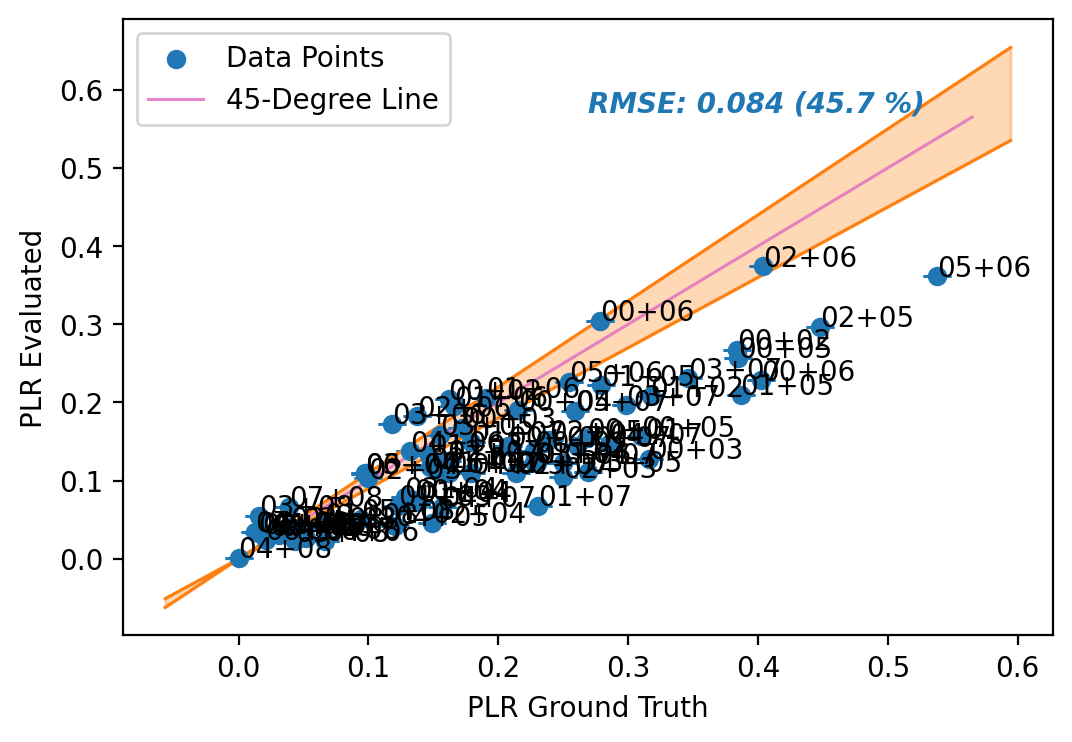

In [7]:
eval = DrEval(filepaths, model_name='BR', model_suffix=suffix, sr_model_id=sr_model_id, dr_model_id=dr_model_id)
eval.run_hist_method(N=1)
eval.plot('BR')

# A: Dual Eval

In [8]:
adjust_table, model_adjust = manipulate_corr_coef(sr_model_id, dr_model_id, route='A', mode=mode, rho_force=None)
# display(adjust_table)
# pprint(model_adjust)

In [9]:
# Dual Radio Example
# dates = data_loader(query_dates=True, show_info=True)

# selected_dates = [s for s in dates if s >= '2023-09-12']
selected_dates = ['2024-03-20']
# excluded_dates = []
# selected_exps = []
# excluded_exps = ['Modem_Action_Test', 'Control_Group', 'Control_Group2', 'Control_Group3']
selected_routes = ['A']
# excluded_routes = []
filepaths = data_loader(mode='dr', selected_dates=selected_dates, selected_routes=selected_routes)

# print(len(filepaths[:36]))
# pprint(filepaths[:36])

./20240329_160006be6c_new_dataset_sync/models/A
./20240329_160006be6c_new_dataset_sync/dr_20240329_1700005690/models/A
./20240329_160006be6c_new_dataset_sync/dr_20240329_1700005690/models/A_dr_prob_models_zero_corr.pkl
0/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#01/data/handover_info_log.csv
0/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#01/data/udp_dnlk_loss_latency.csv
0/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#01/data/udp_uplk_loss_latency.csv
0/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#01/data/handover_info_log.csv
0/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#01/data/udp_dnlk_loss_latency.csv
0/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm00\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm01\#01\data\udp_dnlk_loss_latency.csv
1/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#01/data/handover_info_log.csv
1/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#01/data/udp_dnlk_loss_latency.csv
1/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#01/data/udp_uplk_loss_latency.csv
1/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#01/data/handover_info_log.csv
1/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#01/data/udp_dnlk_loss_latency.csv
1/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm00\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm02\#01\data\udp_dnlk_loss_latency.csv
2/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#01/data/handover_info_log.csv
2/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#01/data/udp_dnlk_loss_latency.csv
2/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#01/data/udp_uplk_loss_latency.csv
2/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#01/data/handover_info_log.csv
2/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#01/data/udp_dnlk_loss_latency.csv
2/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm00\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm03\#01\data\udp_dnlk_loss_latency.csv
3/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#01/data/handover_info_log.csv
3/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#01/data/udp_dnlk_loss_latency.csv
3/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#01/data/udp_uplk_loss_latency.csv
3/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#01/data/handover_info_log.csv
3/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#01/data/udp_dnlk_loss_latency.csv
3/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm00\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm04\#01\data\udp_dnlk_loss_latency.csv
4/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#01/data/handover_info_log.csv
4/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#01/data/udp_dnlk_loss_latency.csv
4/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#01/data/udp_uplk_loss_latency.csv
4/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#01/data/handover_info_log.csv
4/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#01/data/udp_dnlk_loss_latency.csv
4/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm00\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm05\#01\data\udp_dnlk_loss_latency.csv
5/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#01/data/handover_info_log.csv
5/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#01/data/udp_dnlk_loss_latency.csv
5/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#01/data/udp_uplk_loss_latency.csv
5/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#01/data/handover_info_log.csv
5/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#01/data/udp_dnlk_loss_latency.csv
5/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm00\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm06\#01\data\udp_dnlk_loss_latency.csv
6/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#01/data/handover_info_log.csv
6/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#01/data/udp_dnlk_loss_latency.csv
6/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#01/data/udp_uplk_loss_latency.csv
6/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#01/data/handover_info_log.csv
6/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#01/data/udp_dnlk_loss_latency.csv
6/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm00\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm07\#01\data\udp_dnlk_loss_latency.csv
7/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#01/data/handover_info_log.csv
7/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#01/data/udp_dnlk_loss_latency.csv
7/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#01/data/udp_uplk_loss_latency.csv
7/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#01/data/handover_info_log.csv
7/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#01/data/udp_dnlk_loss_latency.csv
7/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm00\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm08\#01\data\udp_dnlk_loss_latency.csv
8/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#01/data/handover_info_log.csv
8/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#01/data/udp_dnlk_loss_latency.csv
8/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#01/data/udp_uplk_loss_latency.csv
8/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#01/data/handover_info_log.csv
8/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#01/data/udp_dnlk_loss_latency.csv
8/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm01\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm02\#01\data\udp_dnlk_loss_latency.csv
9/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#01/data/handover_info_log.csv
9/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#01/data/udp_dnlk_loss_latency.csv
9/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#01/data/udp_uplk_loss_latency.csv
9/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#01/data/handover_info_log.csv
9/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#01/data/udp_dnlk_loss_latency.csv
9/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm01\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm03\#01\data\udp_dnlk_loss_latency.csv
10/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#01/data/handover_info_log.csv
10/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#01/data/udp_dnlk_loss_latency.csv
10/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#01/data/udp_uplk_loss_latency.csv
10/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#01/data/handover_info_log.csv
10/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#01/data/udp_dnlk_loss_latency.csv
10/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm01\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm04\#01\data\udp_dnlk_loss_latency.csv
11/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#01/data/handover_info_log.csv
11/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#01/data/udp_dnlk_loss_latency.csv
11/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#01/data/udp_uplk_loss_latency.csv
11/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#01/data/handover_info_log.csv
11/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#01/data/udp_dnlk_loss_latency.csv
11/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm01\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm05\#01\data\udp_dnlk_loss_latency.csv
12/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#01/data/handover_info_log.csv
12/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#01/data/udp_dnlk_loss_latency.csv
12/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#01/data/udp_uplk_loss_latency.csv
12/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#01/data/handover_info_log.csv
12/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#01/data/udp_dnlk_loss_latency.csv
12/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm01\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm06\#01\data\udp_dnlk_loss_latency.csv
13/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#01/data/handover_info_log.csv
13/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#01/data/udp_dnlk_loss_latency.csv
13/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#01/data/udp_uplk_loss_latency.csv
13/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#01/data/handover_info_log.csv
13/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#01/data/udp_dnlk_loss_latency.csv
13/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm01\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm07\#01\data\udp_dnlk_loss_latency.csv
14/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#01/data/handover_info_log.csv
14/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#01/data/udp_dnlk_loss_latency.csv
14/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#01/data/udp_uplk_loss_latency.csv
14/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#01/data/handover_info_log.csv
14/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#01/data/udp_dnlk_loss_latency.csv
14/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm01\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm08\#01\data\udp_dnlk_loss_latency.csv
15/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#01/data/handover_info_log.csv
15/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#01/data/udp_dnlk_loss_latency.csv
15/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#01/data/udp_uplk_loss_latency.csv
15/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#01/data/handover_info_log.csv
15/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#01/data/udp_dnlk_loss_latency.csv
15/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm02\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm03\#01\data\udp_dnlk_loss_latency.csv
16/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#01/data/handover_info_log.csv
16/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#01/data/udp_dnlk_loss_latency.csv
16/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#01/data/udp_uplk_loss_latency.csv
16/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#01/data/handover_info_log.csv
16/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#01/data/udp_dnlk_loss_latency.csv
16/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm02\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm04\#01\data\udp_dnlk_loss_latency.csv
17/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#01/data/handover_info_log.csv
17/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#01/data/udp_dnlk_loss_latency.csv
17/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#01/data/udp_uplk_loss_latency.csv
17/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#01/data/handover_info_log.csv
17/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#01/data/udp_dnlk_loss_latency.csv
17/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm02\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm05\#01\data\udp_dnlk_loss_latency.csv
18/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#01/data/handover_info_log.csv
18/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#01/data/udp_dnlk_loss_latency.csv
18/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#01/data/udp_uplk_loss_latency.csv
18/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#01/data/handover_info_log.csv
18/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#01/data/udp_dnlk_loss_latency.csv
18/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm02\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm06\#01\data\udp_dnlk_loss_latency.csv
19/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#01/data/handover_info_log.csv
19/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#01/data/udp_dnlk_loss_latency.csv
19/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#01/data/udp_uplk_loss_latency.csv
19/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#01/data/handover_info_log.csv
19/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#01/data/udp_dnlk_loss_latency.csv
19/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm02\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm07\#01\data\udp_dnlk_loss_latency.csv
20/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#01/data/handover_info_log.csv
20/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#01/data/udp_dnlk_loss_latency.csv
20/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#01/data/udp_uplk_loss_latency.csv
20/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#01/data/handover_info_log.csv
20/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#01/data/udp_dnlk_loss_latency.csv
20/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm02\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm08\#01\data\udp_dnlk_loss_latency.csv
21/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#01/data/handover_info_log.csv
21/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#01/data/udp_dnlk_loss_latency.csv
21/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#01/data/udp_uplk_loss_latency.csv
21/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#01/data/handover_info_log.csv
21/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#01/data/udp_dnlk_loss_latency.csv
21/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm03\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm04\#01\data\udp_dnlk_loss_latency.csv
22/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#01/data/handover_info_log.csv
22/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#01/data/udp_dnlk_loss_latency.csv
22/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#01/data/udp_uplk_loss_latency.csv
22/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#01/data/handover_info_log.csv
22/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#01/data/udp_dnlk_loss_latency.csv
22/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm03\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm05\#01\data\udp_dnlk_loss_latency.csv
23/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#01/data/handover_info_log.csv
23/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#01/data/udp_dnlk_loss_latency.csv
23/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#01/data/udp_uplk_loss_latency.csv
23/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#01/data/handover_info_log.csv
23/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#01/data/udp_dnlk_loss_latency.csv
23/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm03\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm06\#01\data\udp_dnlk_loss_latency.csv
24/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#01/data/handover_info_log.csv
24/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#01/data/udp_dnlk_loss_latency.csv
24/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#01/data/udp_uplk_loss_latency.csv
24/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#01/data/handover_info_log.csv
24/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#01/data/udp_dnlk_loss_latency.csv
24/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm03\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm07\#01\data\udp_dnlk_loss_latency.csv
25/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#01/data/handover_info_log.csv
25/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#01/data/udp_dnlk_loss_latency.csv
25/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#01/data/udp_uplk_loss_latency.csv
25/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#01/data/handover_info_log.csv
25/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#01/data/udp_dnlk_loss_latency.csv
25/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm03\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm08\#01\data\udp_dnlk_loss_latency.csv
26/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#01/data/handover_info_log.csv
26/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#01/data/udp_dnlk_loss_latency.csv
26/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#01/data/udp_uplk_loss_latency.csv
26/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#01/data/handover_info_log.csv
26/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#01/data/udp_dnlk_loss_latency.csv
26/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm04\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm05\#01\data\udp_dnlk_loss_latency.csv
27/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#01/data/handover_info_log.csv
27/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#01/data/udp_dnlk_loss_latency.csv
27/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#01/data/udp_uplk_loss_latency.csv
27/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#01/data/handover_info_log.csv
27/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#01/data/udp_dnlk_loss_latency.csv
27/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm04\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm06\#01\data\udp_dnlk_loss_latency.csv
28/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#01/data/handover_info_log.csv
28/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#01/data/udp_dnlk_loss_latency.csv
28/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#01/data/udp_uplk_loss_latency.csv
28/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#01/data/handover_info_log.csv
28/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#01/data/udp_dnlk_loss_latency.csv
28/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm04\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm07\#01\data\udp_dnlk_loss_latency.csv
29/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#01/data/handover_info_log.csv
29/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#01/data/udp_dnlk_loss_latency.csv
29/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#01/data/udp_uplk_loss_latency.csv
29/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#01/data/handover_info_log.csv
29/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#01/data/udp_dnlk_loss_latency.csv
29/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm04\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm08\#01\data\udp_dnlk_loss_latency.csv
30/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#01/data/handover_info_log.csv
30/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#01/data/udp_dnlk_loss_latency.csv
30/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#01/data/udp_uplk_loss_latency.csv
30/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#01/data/handover_info_log.csv
30/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#01/data/udp_dnlk_loss_latency.csv
30/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm05\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm06\#01\data\udp_dnlk_loss_latency.csv
31/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#01/data/handover_info_log.csv
31/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#01/data/udp_dnlk_loss_latency.csv
31/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#01/data/udp_uplk_loss_latency.csv
31/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#01/data/handover_info_log.csv
31/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#01/data/udp_dnlk_loss_latency.csv
31/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm05\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm07\#01\data\udp_dnlk_loss_latency.csv
32/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#01/data/handover_info_log.csv
32/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#01/data/udp_dnlk_loss_latency.csv
32/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#01/data/udp_uplk_loss_latency.csv
32/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#01/data/handover_info_log.csv
32/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#01/data/udp_dnlk_loss_latency.csv
32/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm05\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm08\#01\data\udp_dnlk_loss_latency.csv
33/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#01/data/handover_info_log.csv
33/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#01/data/udp_dnlk_loss_latency.csv
33/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#01/data/udp_uplk_loss_latency.csv
33/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#01/data/handover_info_log.csv
33/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#01/data/udp_dnlk_loss_latency.csv
33/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm06\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm07\#01\data\udp_dnlk_loss_latency.csv
34/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#01/data/handover_info_log.csv
34/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#01/data/udp_dnlk_loss_latency.csv
34/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#01/data/udp_uplk_loss_latency.csv
34/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#01/data/handover_info_log.csv
34/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#01/data/udp_dnlk_loss_latency.csv
34/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm06\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm08\#01\data\udp_dnlk_loss_latency.csv
35/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#01/data/handover_info_log.csv
35/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#01/data/udp_dnlk_loss_latency.csv
35/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#01/data/udp_uplk_loss_latency.csv
35/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#01/data/handover_info_log.csv
35/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#01/data/udp_dnlk_loss_latency.csv
35/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#01/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm07\#01\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm08\#01\data\udp_dnlk_loss_latency.csv
36/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#02/data/handover_info_log.csv
36/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#02/data/udp_dnlk_loss_latency.csv
36/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#02/data/udp_uplk_loss_latency.csv
36/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#02/data/handover_info_log.csv
36/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#02/data/udp_dnlk_loss_latency.csv
36/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm00\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm01\#02\data\udp_dnlk_loss_latency.csv
37/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#02/data/handover_info_log.csv
37/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#02/data/udp_dnlk_loss_latency.csv
37/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#02/data/udp_uplk_loss_latency.csv
37/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#02/data/handover_info_log.csv
37/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#02/data/udp_dnlk_loss_latency.csv
37/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm00\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm02\#02\data\udp_dnlk_loss_latency.csv
38/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#02/data/handover_info_log.csv
38/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#02/data/udp_dnlk_loss_latency.csv
38/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#02/data/udp_uplk_loss_latency.csv
38/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#02/data/handover_info_log.csv
38/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#02/data/udp_dnlk_loss_latency.csv
38/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm00\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm03\#02\data\udp_dnlk_loss_latency.csv
39/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#02/data/handover_info_log.csv
39/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#02/data/udp_dnlk_loss_latency.csv
39/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#02/data/udp_uplk_loss_latency.csv
39/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#02/data/handover_info_log.csv
39/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#02/data/udp_dnlk_loss_latency.csv
39/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm00\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm04\#02\data\udp_dnlk_loss_latency.csv
40/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#02/data/handover_info_log.csv
40/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#02/data/udp_dnlk_loss_latency.csv
40/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#02/data/udp_uplk_loss_latency.csv
40/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#02/data/handover_info_log.csv
40/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#02/data/udp_dnlk_loss_latency.csv
40/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm00\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm05\#02\data\udp_dnlk_loss_latency.csv
41/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#02/data/handover_info_log.csv
41/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#02/data/udp_dnlk_loss_latency.csv
41/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#02/data/udp_uplk_loss_latency.csv
41/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#02/data/handover_info_log.csv
41/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#02/data/udp_dnlk_loss_latency.csv
41/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm00\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm06\#02\data\udp_dnlk_loss_latency.csv
42/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#02/data/handover_info_log.csv
42/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#02/data/udp_dnlk_loss_latency.csv
42/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#02/data/udp_uplk_loss_latency.csv
42/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#02/data/handover_info_log.csv
42/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#02/data/udp_dnlk_loss_latency.csv
42/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm00\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm07\#02\data\udp_dnlk_loss_latency.csv
43/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#02/data/handover_info_log.csv
43/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#02/data/udp_dnlk_loss_latency.csv
43/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm00/#02/data/udp_uplk_loss_latency.csv
43/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#02/data/handover_info_log.csv
43/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#02/data/udp_dnlk_loss_latency.csv
43/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm00\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm08\#02\data\udp_dnlk_loss_latency.csv
44/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#02/data/handover_info_log.csv
44/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#02/data/udp_dnlk_loss_latency.csv
44/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#02/data/udp_uplk_loss_latency.csv
44/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#02/data/handover_info_log.csv
44/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#02/data/udp_dnlk_loss_latency.csv
44/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm01\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm02\#02\data\udp_dnlk_loss_latency.csv
45/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#02/data/handover_info_log.csv
45/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#02/data/udp_dnlk_loss_latency.csv
45/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#02/data/udp_uplk_loss_latency.csv
45/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#02/data/handover_info_log.csv
45/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#02/data/udp_dnlk_loss_latency.csv
45/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm01\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm03\#02\data\udp_dnlk_loss_latency.csv
46/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#02/data/handover_info_log.csv
46/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#02/data/udp_dnlk_loss_latency.csv
46/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#02/data/udp_uplk_loss_latency.csv
46/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#02/data/handover_info_log.csv
46/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#02/data/udp_dnlk_loss_latency.csv
46/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm01\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm04\#02\data\udp_dnlk_loss_latency.csv
47/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#02/data/handover_info_log.csv
47/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#02/data/udp_dnlk_loss_latency.csv
47/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#02/data/udp_uplk_loss_latency.csv
47/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#02/data/handover_info_log.csv
47/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#02/data/udp_dnlk_loss_latency.csv
47/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm01\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm05\#02\data\udp_dnlk_loss_latency.csv
48/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#02/data/handover_info_log.csv
48/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#02/data/udp_dnlk_loss_latency.csv
48/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#02/data/udp_uplk_loss_latency.csv
48/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#02/data/handover_info_log.csv
48/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#02/data/udp_dnlk_loss_latency.csv
48/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm01\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm06\#02\data\udp_dnlk_loss_latency.csv
49/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#02/data/handover_info_log.csv
49/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#02/data/udp_dnlk_loss_latency.csv
49/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#02/data/udp_uplk_loss_latency.csv
49/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#02/data/handover_info_log.csv
49/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#02/data/udp_dnlk_loss_latency.csv
49/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm01\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm07\#02\data\udp_dnlk_loss_latency.csv
50/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#02/data/handover_info_log.csv
50/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#02/data/udp_dnlk_loss_latency.csv
50/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm01/#02/data/udp_uplk_loss_latency.csv
50/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#02/data/handover_info_log.csv
50/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#02/data/udp_dnlk_loss_latency.csv
50/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm01\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm08\#02\data\udp_dnlk_loss_latency.csv
51/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#02/data/handover_info_log.csv
51/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#02/data/udp_dnlk_loss_latency.csv
51/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#02/data/udp_uplk_loss_latency.csv
51/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#02/data/handover_info_log.csv
51/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#02/data/udp_dnlk_loss_latency.csv
51/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm02\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm03\#02\data\udp_dnlk_loss_latency.csv
52/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#02/data/handover_info_log.csv
52/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#02/data/udp_dnlk_loss_latency.csv
52/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#02/data/udp_uplk_loss_latency.csv
52/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#02/data/handover_info_log.csv
52/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#02/data/udp_dnlk_loss_latency.csv
52/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm02\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm04\#02\data\udp_dnlk_loss_latency.csv
53/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#02/data/handover_info_log.csv
53/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#02/data/udp_dnlk_loss_latency.csv
53/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#02/data/udp_uplk_loss_latency.csv
53/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#02/data/handover_info_log.csv
53/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#02/data/udp_dnlk_loss_latency.csv
53/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm02\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm05\#02\data\udp_dnlk_loss_latency.csv
54/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#02/data/handover_info_log.csv
54/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#02/data/udp_dnlk_loss_latency.csv
54/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#02/data/udp_uplk_loss_latency.csv
54/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#02/data/handover_info_log.csv
54/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#02/data/udp_dnlk_loss_latency.csv
54/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm02\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm06\#02\data\udp_dnlk_loss_latency.csv
55/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#02/data/handover_info_log.csv
55/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#02/data/udp_dnlk_loss_latency.csv
55/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#02/data/udp_uplk_loss_latency.csv
55/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#02/data/handover_info_log.csv
55/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#02/data/udp_dnlk_loss_latency.csv
55/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm02\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm07\#02\data\udp_dnlk_loss_latency.csv
56/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#02/data/handover_info_log.csv
56/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#02/data/udp_dnlk_loss_latency.csv
56/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm02/#02/data/udp_uplk_loss_latency.csv
56/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#02/data/handover_info_log.csv
56/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#02/data/udp_dnlk_loss_latency.csv
56/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm02\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm08\#02\data\udp_dnlk_loss_latency.csv
57/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#02/data/handover_info_log.csv
57/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#02/data/udp_dnlk_loss_latency.csv
57/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#02/data/udp_uplk_loss_latency.csv
57/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#02/data/handover_info_log.csv
57/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#02/data/udp_dnlk_loss_latency.csv
57/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm03\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm04\#02\data\udp_dnlk_loss_latency.csv
58/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#02/data/handover_info_log.csv
58/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#02/data/udp_dnlk_loss_latency.csv
58/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#02/data/udp_uplk_loss_latency.csv
58/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#02/data/handover_info_log.csv
58/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#02/data/udp_dnlk_loss_latency.csv
58/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm03\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm05\#02\data\udp_dnlk_loss_latency.csv
59/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#02/data/handover_info_log.csv
59/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#02/data/udp_dnlk_loss_latency.csv
59/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#02/data/udp_uplk_loss_latency.csv
59/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#02/data/handover_info_log.csv
59/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#02/data/udp_dnlk_loss_latency.csv
59/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm03\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm06\#02\data\udp_dnlk_loss_latency.csv
60/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#02/data/handover_info_log.csv
60/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#02/data/udp_dnlk_loss_latency.csv
60/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#02/data/udp_uplk_loss_latency.csv
60/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#02/data/handover_info_log.csv
60/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#02/data/udp_dnlk_loss_latency.csv
60/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm03\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm07\#02\data\udp_dnlk_loss_latency.csv
61/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#02/data/handover_info_log.csv
61/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#02/data/udp_dnlk_loss_latency.csv
61/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm03/#02/data/udp_uplk_loss_latency.csv
61/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#02/data/handover_info_log.csv
61/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#02/data/udp_dnlk_loss_latency.csv
61/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm03\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm08\#02\data\udp_dnlk_loss_latency.csv
62/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#02/data/handover_info_log.csv
62/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#02/data/udp_dnlk_loss_latency.csv
62/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#02/data/udp_uplk_loss_latency.csv
62/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#02/data/handover_info_log.csv
62/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#02/data/udp_dnlk_loss_latency.csv
62/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm04\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm05\#02\data\udp_dnlk_loss_latency.csv
63/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#02/data/handover_info_log.csv
63/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#02/data/udp_dnlk_loss_latency.csv
63/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#02/data/udp_uplk_loss_latency.csv
63/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#02/data/handover_info_log.csv
63/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#02/data/udp_dnlk_loss_latency.csv
63/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm04\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm06\#02\data\udp_dnlk_loss_latency.csv
64/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#02/data/handover_info_log.csv
64/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#02/data/udp_dnlk_loss_latency.csv
64/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#02/data/udp_uplk_loss_latency.csv
64/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#02/data/handover_info_log.csv
64/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#02/data/udp_dnlk_loss_latency.csv
64/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm04\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm07\#02\data\udp_dnlk_loss_latency.csv
65/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#02/data/handover_info_log.csv
65/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#02/data/udp_dnlk_loss_latency.csv
65/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm04/#02/data/udp_uplk_loss_latency.csv
65/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#02/data/handover_info_log.csv
65/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#02/data/udp_dnlk_loss_latency.csv
65/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm04\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm08\#02\data\udp_dnlk_loss_latency.csv
66/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#02/data/handover_info_log.csv
66/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#02/data/udp_dnlk_loss_latency.csv
66/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#02/data/udp_uplk_loss_latency.csv
66/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#02/data/handover_info_log.csv
66/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#02/data/udp_dnlk_loss_latency.csv
66/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm05\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm06\#02\data\udp_dnlk_loss_latency.csv
67/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#02/data/handover_info_log.csv
67/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#02/data/udp_dnlk_loss_latency.csv
67/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#02/data/udp_uplk_loss_latency.csv
67/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#02/data/handover_info_log.csv
67/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#02/data/udp_dnlk_loss_latency.csv
67/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm05\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm07\#02\data\udp_dnlk_loss_latency.csv
68/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#02/data/handover_info_log.csv
68/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#02/data/udp_dnlk_loss_latency.csv
68/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm05/#02/data/udp_uplk_loss_latency.csv
68/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#02/data/handover_info_log.csv
68/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#02/data/udp_dnlk_loss_latency.csv
68/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm05\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm08\#02\data\udp_dnlk_loss_latency.csv
69/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#02/data/handover_info_log.csv
69/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#02/data/udp_dnlk_loss_latency.csv
69/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#02/data/udp_uplk_loss_latency.csv
69/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#02/data/handover_info_log.csv
69/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#02/data/udp_dnlk_loss_latency.csv
69/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm06\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm07\#02\data\udp_dnlk_loss_latency.csv
70/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#02/data/handover_info_log.csv
70/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#02/data/udp_dnlk_loss_latency.csv
70/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm06/#02/data/udp_uplk_loss_latency.csv
70/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#02/data/handover_info_log.csv
70/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#02/data/udp_dnlk_loss_latency.csv
70/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm06\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm08\#02\data\udp_dnlk_loss_latency.csv
71/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#02/data/handover_info_log.csv
71/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#02/data/udp_dnlk_loss_latency.csv
71/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm07/#02/data/udp_uplk_loss_latency.csv
71/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#02/data/handover_info_log.csv
71/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#02/data/udp_dnlk_loss_latency.csv
71/72 /home/wmnlab/F/database/2024-03-20/UDP_Bandlock_9S_Phone_A/sm08/#02/data/udp_uplk_loss_latency.csv


  0%|                                                                                                         …

/home/wmnlab/F/results/20240329_160006be6c_new_dataset_sync/dr_results/dr_20240329_1700005690/20240329_20211100001_fb005358906a2528_zero_corr/\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm07\#02\data\udp_dnlk_loss_latency\home\wmnlab\F\database\2024-03-20\UDP_Bandlock_9S_Phone_A\sm08\#02\data\udp_dnlk_loss_latency.csv
./20240329_160006be6c_new_dataset_sync/dr_20240329_1700005690/figures/20240329_A_zero_corr_20211100001_fb005358906a2528.png


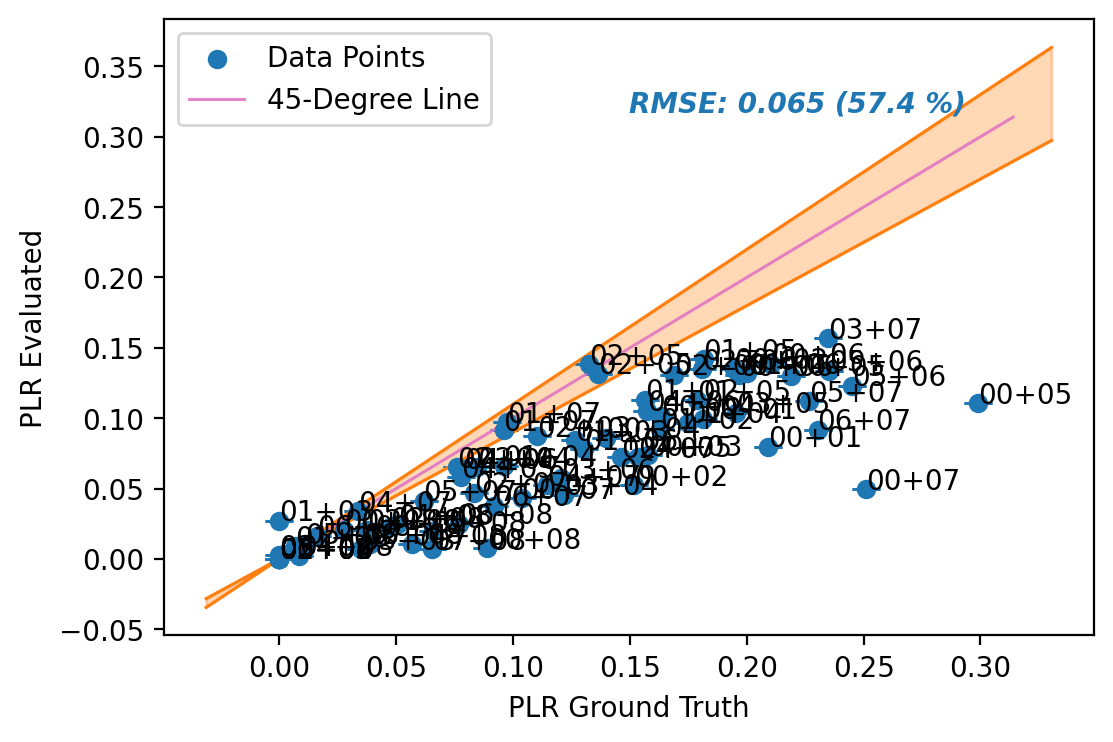

In [10]:
eval = DrEval(filepaths, model_name='A', model_suffix=suffix, sr_model_id=sr_model_id, dr_model_id=dr_model_id)
eval.run_hist_method(N=1)
eval.plot('A')

# Show Model IDs

In [11]:
print('SR Model ID:', sr_model_id)
print('DR Model ID:', dr_model_id)


SR Model ID: 20240329_160006be6c_new_dataset_sync
DR Model ID: dr_20240329_1700005690
